In [61]:
import pandas as pd
import numpy as np
import itertools
from sklearn.metrics import r2_score, classification_report, roc_curve, auc, confusion_matrix, precision_recall_curve, mean_absolute_error
from sklearn.preprocessing import label_binarize

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [62]:

def plot_confusion_matrix(
    working_dir, cm, target_names, title="Confusion matrix", cmap=None, normalize=False
):
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap("Blues")

    plt.figure(figsize=(9, 8))
    plt.imshow(cm, interpolation="nearest", cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(
                j,
                i,
                f"{cm[i, j]:0.4f}",
                horizontalalignment="center",
                color="black",
                # color="white" if cm[i, j] > thresh else "black",
            )
        else:
            plt.text(
                j,
                i,
                f"{cm[i, j]:,}",
                horizontalalignment="center",
                color="black",
                # color="white" if cm[i, j] > thresh else "black",
            )

    plt.ylabel("True label")
    plt.xlabel(f"Predicted label\naccuracy={accuracy:0.4f}; misclass={misclass:0.4f}")

    #plt.savefig(os.path.join(working_dir, title + ".pdf"))
    #plt.savefig(os.path.join(working_dir, title + ".png"))
    #plt.clf()


def print_classification_report(y_true, y_pred):
    """
    Prints classification report to stdout.

    Args:
        y_true (nparray): 1D npy array containing int values for class
        y_pred (nparray): 1D npy array containing int values for predicted class
        train_gen (Keras Generator): Training generator used for model training, used for labels
    """
    print("Classification Report")
    print(classification_report(y_true, y_pred))



In [63]:
df = pd.read_csv("TP_SHIC_res.csv")
df.head()



,rep,sweep,selcoeff,pred_class,neut_prob,sdn_prob,ssv_prob,sdn_pred_s,ssv_pred_s
0,0,neut,0.194983,0,0.520371,0.202742,0.276887,0.061183,0.059168
1,0,sdn,0.068915,0,0.573763,0.190137,0.236100,0.033433,0.059415
2,0,ssv,0.014222,0,0.440146,0.236893,0.322961,0.080455,0.102627
3,1,neut,0.195803,0,0.601179,0.174347,0.224474,0.048792,0.061011
4,1,sdn,0.143512,1,0.083108,0.482789,0.434103,0.106391,0.130415


In [64]:
lab_dict = {0: "neut", 1: "sdn", 2: "ssv"}
dict_lab = {v:k for k,v in lab_dict.items()}
df["str_swp"] = [lab_dict[i] for i in df["pred_class"]] 
df["true"] = [dict_lab[i] for i in df["sweep"]]

Classification Report
              precision    recall  f1-score   support

        neut       0.60      0.91      0.73      4994
         sdn       0.60      0.53      0.56      4997
         ssv       0.54      0.32      0.40      4998

    accuracy                           0.59     14989
   macro avg       0.58      0.59      0.56     14989
weighted avg       0.58      0.59      0.56     14989



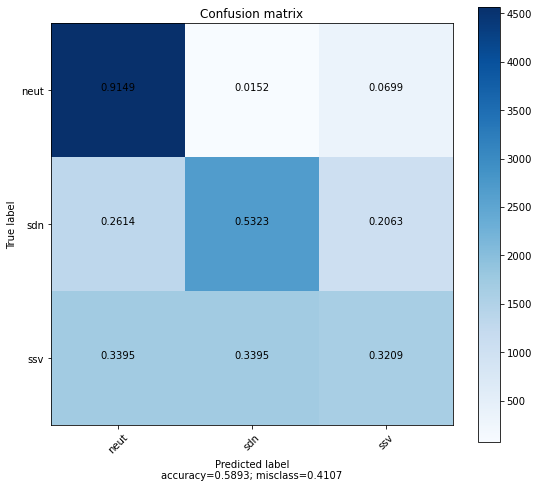

In [65]:
print_classification_report(df["sweep"], df["str_swp"])
plot_confusion_matrix('.', confusion_matrix(df["sweep"], df["str_swp"]), list(lab_dict.values()), normalize=True)


Classification Report
              precision    recall  f1-score   support

        neut       0.60      0.91      0.73      4994
         sdn       0.60      0.53      0.56      4997
         ssv       0.54      0.32      0.40      4998

    accuracy                           0.59     14989
   macro avg       0.58      0.59      0.56     14989
weighted avg       0.58      0.59      0.56     14989



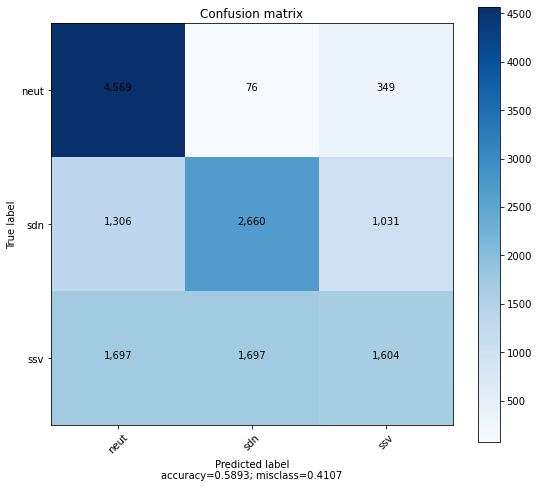

In [66]:
testdf = df.copy()
testdf.head()

testdf.loc[(testdf["str_swp"] == "neut") & (testdf["ssv_prob"] > 0.4), "str_swp"] = "ssv"
testdf
print_classification_report(testdf["sweep"], testdf["str_swp"])
plot_confusion_matrix('.', confusion_matrix(testdf["sweep"], testdf["str_swp"]), list(lab_dict.values()))

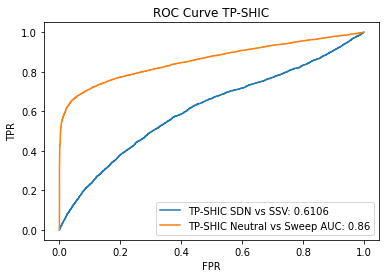

In [67]:
"""Plot ROC curve by binarizing neutral/sweep."""

# Plot sdn/ssv distinction
sweep_idxs = np.transpose(np.array((df["true"] > 0)).nonzero())
sweep_labs = np.array(df["true"])[sweep_idxs]

sdn_probs = df[df["true"] > 0]["sdn_prob"]

swp_fpr, swp_tpr, thresh = roc_curve(sweep_labs, sdn_probs, pos_label=1)
swp_auc_val = auc(swp_fpr, swp_tpr)
plt.plot(
    swp_fpr,
    swp_tpr,
    label=f"TP-SHIC SDN vs SSV: {swp_auc_val:.4}",
)

# Coerce all ssvs into sweep binary pred
labs = np.array(df["true"])
labs[labs > 1] = 1
pred_probs = np.sum(np.array([df["sdn_prob"], df["ssv_prob"]]).T, axis=1)

# Plot ROC Curve
fpr, tpr, thresh = roc_curve(labs, pred_probs)
auc_val = auc(fpr, tpr)
plt.plot(fpr, tpr, label=f"TP-SHIC Neutral vs Sweep AUC: {auc_val:.2}")

plt.title(f"ROC Curve TP-SHIC")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.legend()

plt.show()

Text(0, 0.5, 'Precision')

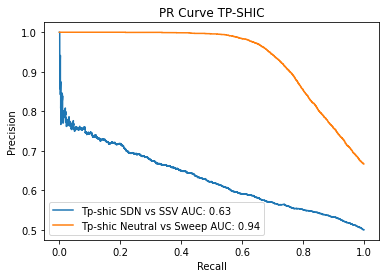

In [68]:
name="TP-SHIC"
"""Plot PR curve by binarizing neutral/sweep."""
# Plot sdn/ssv distinction

filt_df = df[(df["sdn_prob"] > 0.0) & (df["ssv_prob"] > 0.0)]

sweep_idxs = np.transpose(np.array((filt_df["true"] > 0)).nonzero())
sweep_labs = np.array(filt_df["true"])[sweep_idxs]

sweep_labs[sweep_labs == 1] = 1
sweep_labs[sweep_labs == 2] = 0

if len(np.unique(filt_df["true"])) > 2:
    sdn_probs = filt_df[filt_df["true"] > 0]["sdn_prob"] / (
        filt_df[filt_df["true"] > 0]["sdn_prob"]
        + filt_df[filt_df["true"] > 0]["ssv_prob"]
    )

    swp_prec, swp_rec, swp_thresh = precision_recall_curve(
        sweep_labs.flatten(), sdn_probs
    )
    swp_auc_val = auc(swp_rec, swp_prec)
    plt.plot(
        swp_rec,
        swp_prec,
        label=f"{name.capitalize()} SDN vs SSV AUC: {swp_auc_val:.2}",
    )

# Coerce all ssvs into sweep binary pred
labs = np.array(df["true"])
labs[labs > 1] = 1
pred_probs = np.sum(np.array([df["sdn_prob"], df["ssv_prob"]]).T, axis=1)

# Plot PR Curve for binarized labs
prec, rec, thresh = precision_recall_curve(labs, pred_probs)
auc_val = auc(rec, prec)
plt.plot(rec, prec, label=f"{name.capitalize()} Neutral vs Sweep AUC: {auc_val:.2}")

plt.title(f"PR Curve {name}")
plt.legend()
plt.xlabel("Recall")
plt.ylabel("Precision")

In [69]:
df[df["sweep"] == "ssv"].describe()

,rep,selcoeff,pred_class,neut_prob,sdn_prob,ssv_prob,sdn_pred_s,ssv_pred_s,true
count,4998.000000,4998.000000,4998.000000,4.998000e+03,4998.000000,4998.000000,4998.000000,4998.000000,4998.0
mean,2500.540216,0.125913,0.981393,2.195435e-01,0.385975,0.394481,0.102847,0.122439,2.0
std,1443.735374,0.071147,0.812558,2.390229e-01,0.160273,0.114131,0.045368,0.045933,0.0
min,0.000000,0.000261,0.000000,9.883543e-07,0.113709,0.144843,0.030698,0.047896,2.0
25%,1251.250000,0.064296,0.000000,4.954035e-03,0.220752,0.286002,0.061698,0.074224,2.0
50%,2500.500000,0.127084,1.000000,7.623497e-02,0.395996,0.407593,0.100709,0.128699,2.0
75%,3750.750000,0.186685,2.000000,4.823535e-01,0.520736,0.481640,0.138260,0.162139,2.0
max,5000.000000,0.249961,2.000000,7.394046e-01,0.774301,0.729071,0.250823,0.255943,2.0


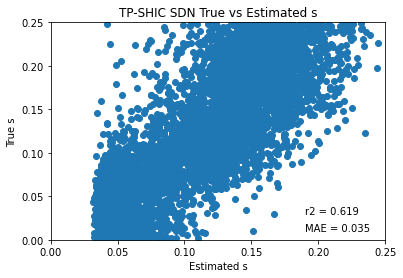

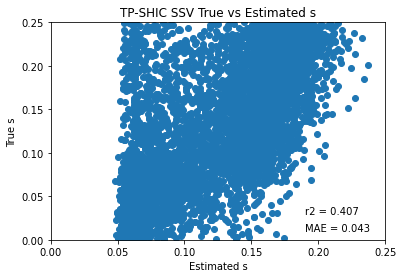

<Figure size 432x288 with 0 Axes>

In [70]:
#Filter to the true values
for swp in df["sweep"].unique():
    subdf = df[df["sweep"] == swp].dropna()
    if swp == "neut":
        continue
    else:
        plt.scatter(x=subdf[f"{swp}_pred_s"], y=subdf["selcoeff"])
        
    plt.xlim(0, .25)
    plt.ylim(0, .25)
    plt.annotate("r2 = {:.3f}".format(r2_score(subdf["selcoeff"], subdf[f"{swp}_pred_s"])), (0.19, 0.03))
    plt.annotate("MAE = {:.3f}".format(mean_absolute_error(subdf["selcoeff"], subdf[f"{swp}_pred_s"])), (0.19, 0.01))
    plt.title(f"TP-SHIC {swp.upper()} True vs Estimated s") 
    plt.xlabel("Estimated s") 
    plt.ylabel("True s") 
    plt.savefig(f"{swp}_true_v_est_ts.pdf")
    plt.show()
    plt.clf()

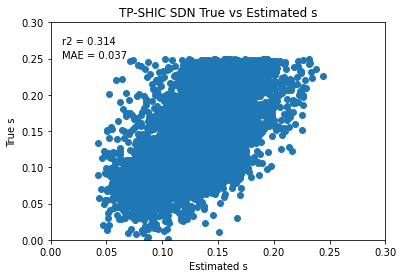

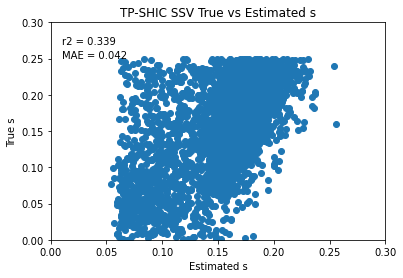

<Figure size 432x288 with 0 Axes>

In [71]:
#Filter to the predicted classes
for swp in df["sweep"].unique():
    subdf = df[df["str_swp"] == swp].dropna()
    if swp == "neut":
        continue
    else:
        plt.scatter(x=subdf[f"{swp}_pred_s"], y=subdf["selcoeff"])
        
        
    plt.xlim(0, .3)
    plt.ylim(0, .3)
    plt.annotate("r2 = {:.3f}".format(r2_score(subdf["selcoeff"], subdf[f"{swp}_pred_s"])), (0.01, 0.27))
    plt.annotate("MAE = {:.3f}".format(mean_absolute_error(subdf["selcoeff"], subdf[f"{swp}_pred_s"])), (0.01, 0.25))
    plt.title(f"TP-SHIC {swp.upper()} True vs Estimated s") 
    plt.xlabel("Estimated s") 
    plt.ylabel("True s") 
    plt.savefig(f"{swp}_true_v_est_tp-shic.pdf")
    plt.show()
    plt.clf()